<a href="https://colab.research.google.com/github/ehsan-lari/pyro101/blob/main/pyro_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bayesian Neural Networks

### 1. Data

In [ ]:
%pip install -q pyro-ppl

In [ ]:
import torch
import numpy as np
from torch.distributions import constraints
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pyro
from pyro.distributions import Normal, Gamma, MultivariateNormal, Poisson, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

In [ ]:
torch.manual_seed(42)

N_SAMPLE = 500
x_train = -10.5 + 21 * torch.rand(size=(N_SAMPLE, 1))
r_train = 3 * torch.rand(size=(N_SAMPLE, 1))
y_train = 7.0 * torch.sin(0.75 * x_train) + x_train * 0.5 + r_train

x_test = torch.arange(-20.5, 20.5, 0.1).reshape(-1, 1)
# y_test = 7.0 * torch.sin(0.75 * x_test) + x_test * 0.5

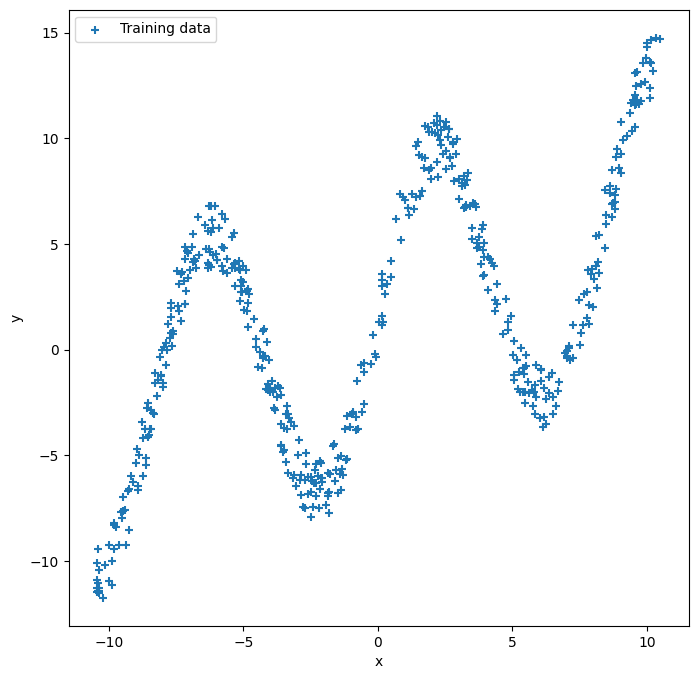

In [135]:
plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# plt.figure(figsize=(8, 8))
# sns.scatterplot(x=x_train.squeeze(), y=y_train.squeeze(), label='Training data', markers={'+'})
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show()

### 2. Training NN

In [ ]:
class NeuralNetwork():
    def __init__(self, N_HIDDEN):
        self.w = nn.Parameter(torch.randn(size=(1, N_HIDDEN)))
        self.b = nn.Parameter(torch.randn(size=(1, N_HIDDEN)))
        self.w_out = nn.Parameter(torch.randn(size=(N_HIDDEN, 1)))
        self.b_out = nn.Parameter(torch.randn(size=(1, 1)))

    def params(self):
        return {"w:": self.w, "b":self.b, "w_out:": self.w_out, "b_out":self.b_out}

    def forward(self, x):
        x = nn.Tanh()(torch.matmul(x, self.w) + self.b)
        x = torch.matmul(x, self.w_out) + self.b_out
        return x

In [ ]:
N_HIDDEN = 20
NeuralNet = NeuralNetwork(N_HIDDEN)

optimizer = torch.optim.Adam(NeuralNet.params().values(), lr=1e-1)
loss_fn = nn.MSELoss(reduction="sum")
N_ITERATIONS = 1000

for iter in range(N_ITERATIONS):
  y_pred = NeuralNet.forward(x_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (iter+1) % 100 == 0:
    print(f"Iter: {iter+1}, Loss: {loss.item()}")

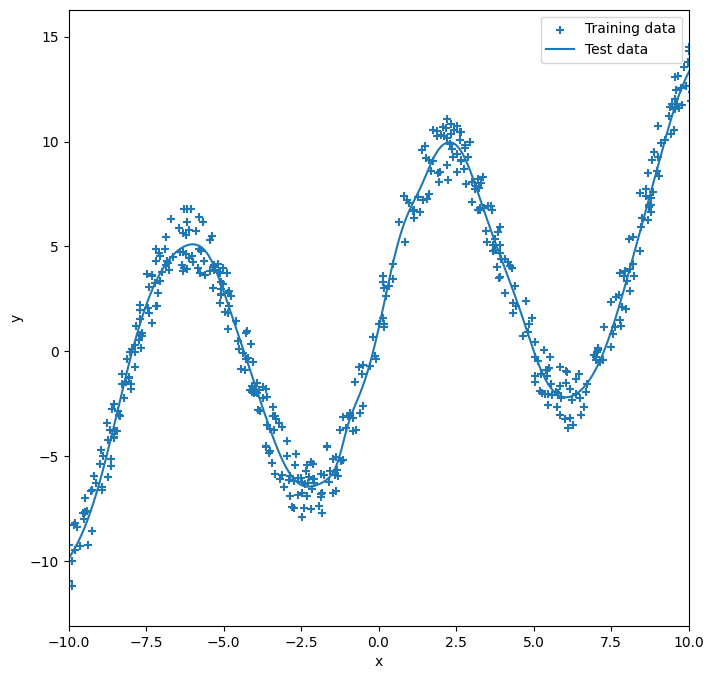

In [133]:
y_test = NeuralNet.forward(x_test)

plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.plot(x_test.detach().numpy(), y_test.detach().numpy(), label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-10, 10])
plt.legend()
plt.show()

### 3. Bayesian Learning of NN

In [127]:
def model(N_HIDDEN, x_train, y_train):

  w = pyro.sample("w", Normal(loc=torch.zeros([1, N_HIDDEN]), scale=1.).to_event())
  b = pyro.sample("b", Normal(loc=torch.zeros([1, N_HIDDEN]), scale=1.).to_event())

  w_out = pyro.sample("w_out", Normal(loc=torch.zeros([N_HIDDEN, 1]), scale=1.).to_event())
  b_out = pyro.sample("b_out", Normal(loc=torch.zeros([1, 1]), scale=1.).to_event())

  hidden_layer = nn.Tanh()(torch.matmul(x_train, w) + b)
  out = torch.matmul(hidden_layer, w_out) + b_out
  predictive_mean = pyro.deterministic("predictive_mean", out)

  with pyro.plate("data", len(x_train)):
    pyro.sample("y", Normal(loc=predictive_mean, scale=1.).to_event(1), obs=y_train)

In [129]:
from pyro.infer.autoguide import AutoNormal

adam_args = {"lr": 1e-1}
optimizer = Adam(adam_args)
guide = AutoNormal(model)

pyro.clear_param_store()

svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=10)
train_ELBO = []

EPOCH = 3000

for epoch in range(EPOCH):
  loss = svi.step(N_HIDDEN, x_train, y_train)
  train_ELBO.append(-loss)
  if (epoch+1) % 500 == 0:
    print(f"Epoch: {epoch+1}, ELBO: {-loss}")

/usr/local/lib/python3.11/dist-packages/pyro/infer/svi.py:57: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  warnings.warn(


Epoch: 500, ELBO: -1045.9429906606674
Epoch: 1000, ELBO: -1018.0793725252151
Epoch: 1500, ELBO: -1082.3469936847687
Epoch: 2000, ELBO: -1074.730572938919
Epoch: 2500, ELBO: -1107.8529379367828
Epoch: 3000, ELBO: -1069.9249809980392


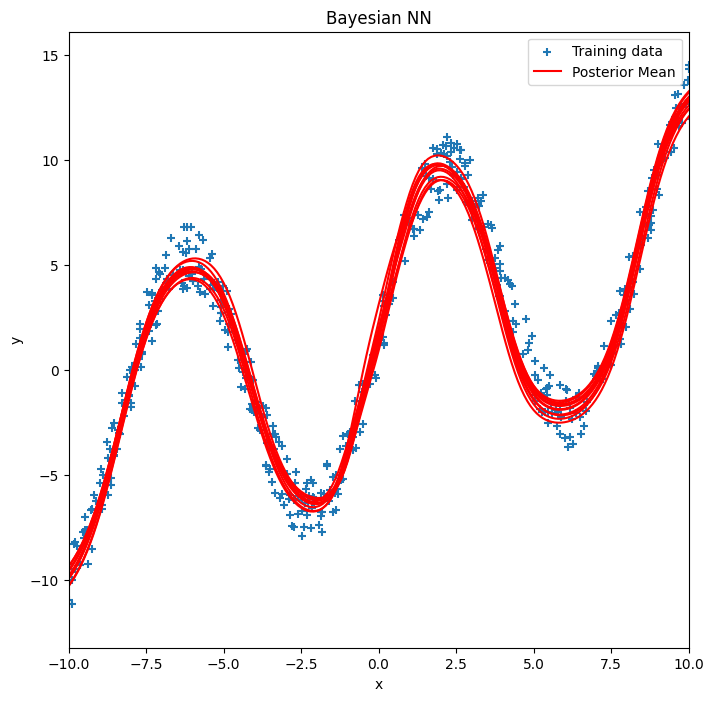

In [132]:
plt.figure(figsize=(8, 8))

predictive = pyro.infer.Predictive(model, guide=guide, num_samples=10)
predictive_samples = predictive(N_HIDDEN, x_test, None)["predictive_mean"]

y_predictive_mean = torch.squeeze(predictive_samples).detach().numpy()

for i in range(y_predictive_mean.shape[0]):
  plt.plot(x_test.detach().numpy(), y_predictive_mean[i], color='red')

y_pred = torch.squeeze(predictive_samples).detach().numpy()

y_mean = np.mean(y_pred, axis=0)
y_sigma = np.std(y_pred, axis=0)

plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.plot(x_test.detach().numpy(), y_mean, 'r-', label='Posterior Mean')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian NN')
plt.xlim([-10, 10])
plt.legend()
plt.show()